In [ ]:
"""
3D Gaussian Splatting (volumetric, rasterization)
1. initialize 3D gaussians
    - differentiable volumetric representation
2. optimize anisotropic covariance
3. visibility-aware rendering algorithm

Allows high quality and real-time rendering

VS Nerfs (ray tracing)
 - high quality but slow training
 - fast training with hash encoding / , but slow rendering
 - importance sampling and positional encoding, but still slow
 - struggle with empty space since neural networks are "continuos"
Inputs:
 - Only use SFM (Colmap)
 - MVS data (dense reconstruction, color, depth, normals, confidence)
    - re-project and blend input images, but fail to recover "unreconstructred or over-reconstructed" regions
    - so new methods leverage GPU that reduce artifacts
 - Initialize 150k gaussians with SFM points. For nerf-synthetic, even randomized points do well

Gaussian points --> project to 2D, then apply alpha blending
  - Like NeRF, trace depth
   - initially tried with points, but there were holes so moved to "splatts" or circular / elliptic discs
    - also, initial methods still depended on MVS

Optimization:
 - 3D position
 - opacity alpha
 - anisotropic covariance
 - spherical harmonic coefficients

- blended with adaptive density control
 - add more gaussians
 - remove gaussians

Real-time rendering:
 - tile-based rasterization GPU sorting
 - alpha blending (visibility-aware). Allows fast forward and backward pass

Alpha blending (like NeRF)
 - samples point along a ray
 - compute density (color) at each point
    - C = T*alpha*(cumulative)

"""

In [17]:
points3D_data[59796]

{'xyz': array([-1.0778622 ,  1.32568156,  1.96777268]),
 'rgb': array([120, 105, 103]),
 'error': 0.4256980116973188,
 'track': [(185, 533), (186, 1363), (188, 517), (189, 479), (187, 1221)]}

In [1]:
import struct
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [26]:
def read_cameras_binary(file_path):
    """
    Read COLMAP camera binary file (cameras.bin).
    Returns a dictionary mapping camera_id to a dictionary containing camera parameters.
    """
    cameras = {}
    with open(file_path, "rb") as f:
        num_cameras = struct.unpack("Q", f.read(8))[0]
        for _ in range(num_cameras):
            camera_id = struct.unpack("i", f.read(4))[0]
            model_id = struct.unpack("i", f.read(4))[0]
            width = struct.unpack("Q", f.read(8))[0]
            height = struct.unpack("Q", f.read(8))[0]
            params = []
            num_params = {
                0: 3,  # SIMPLE_PINHOLE
                1: 4,  # PINHOLE
                2: 5,  # SIMPLE_RADIAL
                3: 6,  # RADIAL
                4: 8,  # OPENCV
                5: 8,  # OPENCV_FISHEYE
                6: 12, # FULL_OPENCV
                7: 3,  # SIMPLE_RADIAL_FISHEYE
                8: 4,  # RADIAL_FISHEYE
                9: 5,  # THIN_PRISM_FISHEYE
            }[model_id]
            for _ in range(num_params):
                params.append(struct.unpack("d", f.read(8))[0])
            
            cameras[camera_id] = {
                "model_id": model_id,
                "width": width,
                "height": height,
                "params": params
            }
    return cameras

# Usage example:
cameras_file = "data/cameras.bin"  # Update path to your cameras.bin file
cameras_data = read_cameras_binary(cameras_file)

# Print first camera info
if cameras_data:
    first_camera_id = list(cameras_data.keys())[0]
    print(f"Camera {first_camera_id} info:")
    print(cameras_data[first_camera_id])

Camera 1 info:
{'model_id': 4, 'width': 960, 'height': 540, 'params': [556.9740875009339, 553.8176655260585, 480.0, 270.0, 0.00527160502148155, -0.007437133878853077, 0.0032169834001347657, 0.013468197350392126]}


Loaded 56042 points


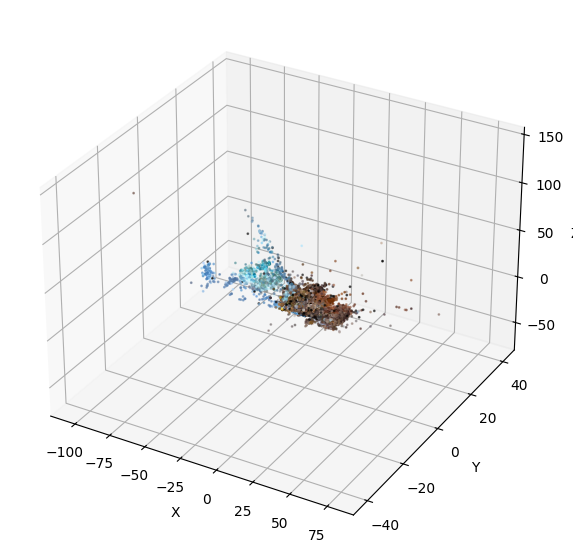

In [21]:


def read_points3D_binary(file_path):
    points3D = {}
    with open(file_path, "rb") as f:
        num_points = struct.unpack("Q", f.read(8))[0]
        for _ in range(num_points):
            point_id = struct.unpack("Q", f.read(8))[0]
            xyz = struct.unpack("ddd", f.read(24))  # X, Y, Z
            rgb = struct.unpack("BBB", f.read(3))   # R, G, B
            error = struct.unpack("d", f.read(8))[0]
            track_length = struct.unpack("Q", f.read(8))[0]
            track = []
            for _ in range(track_length):
                image_id, feature_id = struct.unpack("ii", f.read(8))
                track.append((image_id, feature_id))
            points3D[point_id] = {
                "xyz": np.array(xyz),
                "rgb": np.array(rgb),
                "error": error,
                "track": track
            }
    return points3D

def visualize_point_cloud(points, colors, title="3D Point Cloud"):
    # Matplotlib visualization
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

    # Open3D visualization
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd], window_name=title)

# not noticing significant difference
points3D_file = "data/dense_points3D.bin"
# points3D_file = "data/points3D.bin"
points3D_data = read_points3D_binary(points3D_file)

points = np.array([v["xyz"] for v in points3D_data.values()])
colors = np.array([v["rgb"] / 255.0 for v in points3D_data.values()])

print(f"Loaded {len(points)} points")

visualize_point_cloud(points, colors)

Loaded 57195 points


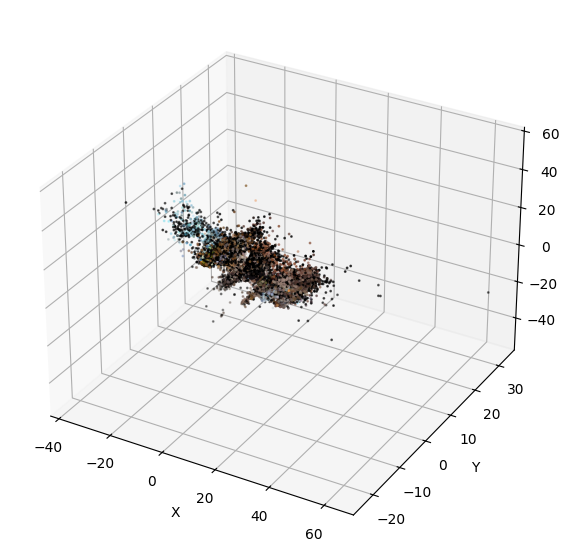

In [8]:
import struct
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

# Load and visualize PLY file
ply_file = r"C:\Users\mjkim\OneDrive\Work\gaussian-splatting\models\bicycle\input.ply"  # Update path to your PLY file
ply_file = "data/points3D.ply"
pcd = o3d.io.read_point_cloud(ply_file)

# Print summary
print(f"Loaded {len(pcd.points)} points")

# Visualize using matplotlib
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

# Visualize using Open3D
o3d.visualization.draw_geometries([pcd], window_name="3D Point Cloud")
